In [1]:
import scipy.stats as stats
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import imageio as im
from pathlib import Path
from PIL import Image

In [2]:
tests = ['AA', 'AB']
metrics = ['FPR', 'TPR']
control_test_kwargs = {'stat': 'probability'}
sns.set_theme()
sns.set_palette('muted')

In [3]:
#для генерации просмотров сыэмплируем логнормальное распределение, берем модуль и приводим к целочисленному типа
#т.к. сложно представить себе полтора просмотра
def generate_views(samples: int, experiments: int, skew: float):
    control = np.absolute(
        stats.lognorm(s=skew).rvs(
            size=samples * experiments
                ).astype(np.int)
            ).reshape(samples, experiments) + 1
    test = np.absolute(
        stats.lognorm(s=skew).rvs(
            size=samples * experiments
                ).astype(np.int)
            ).reshape(samples, experiments) + 1
    return {'data' :np.array([control, test]), 'stats': {'skew': skew}}

#генерим истинные ctr для каждого юзера из бета-распределения
#добавляем возможность накинуть аплифт для АБ
def generate_ctrs(samples: int, experiments: int, mean_ctr: float, uplift: float, beta: float):
    alpha_cont = mean_ctr * beta / (1- mean_ctr)
    control = stats.beta(alpha_cont, beta).rvs(size=samples * experiments).reshape(samples, experiments)
    alpha_test = mean_ctr * (1 + uplift) * beta / (1- mean_ctr * (1 + uplift))
    test = stats.beta(alpha_test, beta).rvs(size=samples * experiments).reshape(samples, experiments)
    std = stats.beta.stats(alpha_cont, beta)[1]**0.5
    return {'data' :np.array([control, test]), 'stats': {'std': std, 'mean': mean_ctr, 'uplift': uplift}}

#генерим клики, сэмплируя из биномиального распределения с p=ctr, n=просмотры
def generate_clicks(views, p):
    control = stats.binom(n=views['data'][0], p=p['data'][0]).rvs()
    test = stats.binom(n=views['data'][1], p=p['data'][1]).rvs()
    return {'data': np.array([control, test]), 'stats': dict()}

#пишем обертку для генерации всего сразу
#потом надо будет переписать, т.к. тупо каждый раз заново генерить ctr, если я его фиксирую в рамках симуляции
def generate_wrapper(samples=5000, experiments=2000, views_skew=1, mean_ctr=0.03, uplift=0.0, beta=1000.0):
    views = generate_views(samples=samples, experiments=experiments, skew=views_skew)
    ctrs = generate_ctrs(samples=samples, experiments=experiments, mean_ctr=mean_ctr, uplift=uplift, beta=beta)
    clicks = generate_clicks(views=views, p=ctrs)
    res = {'data':
        {
            "control": np.array([views['data'][0].astype(np.int), clicks['data'][0].astype(np.int), ctrs['data'][0]]),
            "test": np.array([views['data'][1].astype(np.int), clicks['data'][1].astype(np.int), ctrs['data'][1]]),
        },
        "stats": {
            'views': views['stats'],
            'clicks': clicks['stats'],
            'ctrs': ctrs['stats']
        }
    }
    return res

In [4]:
#Генерим данные для АА и для АБ
dict_aa = generate_wrapper()
data_aa = dict_aa['data']
stats_aa = dict_aa['stats']
dict_ab = generate_wrapper(uplift=0.2)
data_ab = dict_ab['data']
stats_ab = dict_ab['stats']

In [5]:
def t_test(control, test):
    return stats.ttest_ind(control, test).pvalue

In [6]:
#руками считаем бины, чтобы не воевать с ecdf
def cdfer(pvals, thresh=0.05):
    pvals_count, edges = np.histogram(pvals, bins=500)
    pvals_count = np.cumsum(pvals_count)/len(pvals)
    pvals_count = np.append(pvals_count, [1.0])
    fpr = pvals_count[np.where(edges<=thresh)][-1]
    return {'pval_cum': pvals_count, 'bin_edges': edges, 'fpr': fpr, 'thresh': thresh}

In [7]:
def dash_drawer(data_aa, data_ab, stats_aa, control_test_kwargs):
#готовим грид
    fig = plt.figure(figsize=(16,9), constrained_layout = True)
    subfigs = fig.subfigures(1,2, width_ratios = [2.7, 1.3], wspace=0.06)
    tests_sf = subfigs[0]
    ax_tests = tests_sf.subplots(2,2)
    distribs_sf = subfigs[1]
    ax_distribs = distribs_sf.subplots(3,1, gridspec_kw={'hspace': 0.1})
    fig.suptitle("Влияние параметров распределения на мощность и FPR t-теста", fontsize='xx-large')

    #собираем данные
    pvals_aa = t_test(control=data_aa['control'][1], test=data_aa['test'][1])
    pvals_ab = t_test(control=data_ab['control'][1], test=data_ab['test'][1])
    aa_stats = cdfer(pvals_aa)
    ab_stats = cdfer(pvals_ab)

    #для создания seaborn-friendly длинных таблиц
    def df_creator(data: dict, ind: int):
        df = pd.DataFrame({'control': data_aa['control'][ind].ravel(), 'test': data_aa['test'][ind].ravel()}).melt()
        df = df.rename(columns={'variable': 'Группа'})
        return df
    
    #для создания pdf-гистограмм
    def pdf_creator(data, ind, test_type):
        fig = sns.histplot(data=data, ax=ax_tests[ind][0], stat='probability', bins=np.linspace(0, 1, num=20))
        fig.set_title(f'P-value для {test_type}-теста')
        return fig

    #для создания cdf-гистограмм p-value
    def cdf_creator(exp_stats, ind, test_type, metric):
        thresh = exp_stats['thresh']
        fpr = exp_stats['fpr']
        fig=sns.lineplot(x=exp_stats['bin_edges'], y=exp_stats['pval_cum'], ax=ax_tests[ind][1])
        fig.plot([0,1], [0,1], color='gray', linestyle='--')
        fig.axvline(thresh, color='gray')
        fig.plot(thresh, fpr, 'ro')
        fig.text(x=thresh+0.01, y=fpr-0.02, s=f'{metric}:{fpr*100:.2f}%')
        fig.text(x=thresh+0.01, y=0.95, s=f'{thresh*100}%')
        fig.set_title(f'P-value CDF для {test_type} теста')
        return fig    

    #делаем гистограмму распределения просмотров
    fig_views=sns.histplot(data=data_aa['control'].astype(np.int)[0].ravel(), ax=ax_distribs[0], bins=range(0,20), stat='probability')
    fig_views.set_xlim(0, 20)
    fig_views.set_xticks(np.linspace(0, 20, num=5))
    fig_views.set_title(f'Распределение просмотров, skew={stats_aa["views"]["skew"]:.3f}')
    fig_views.legend([], [], frameon=False)
    #делаем гистограмму распределения кликов
    clicks_df = df_creator(data=data_aa, ind=1)
    clicks_df['value'] = clicks_df['value'].astype(np.int)
    fig_clicks = sns.histplot(data=clicks_df, ax=ax_distribs[1], bins=range(0,10), **control_test_kwargs)
    fig_clicks.set_xlim(0, 10)
    fig_clicks.set_title('Форма распределения кликов')
    fig_clicks.set_xlabel('')
    fig_clicks.legend([], [], frameon=False)
    #делаем гистограмму распределения CTR
    ctr_df = df_creator(data=data_aa, ind=2)
    fig_ctr = sns.histplot(data=ctr_df, ax=ax_distribs[2], bins=30, **control_test_kwargs)
    fig_ctr.set_title(f'Форма распределения CTR, std={stats_aa["ctrs"]["std"]:.3f}')
    fig_ctr.set_xlabel('')
    fig_ctr.legend([], [], frameon=False)
    #делаем PDF для АА-теста
    for i, exp_stats  in enumerate([pvals_aa, pvals_ab]):
        pdf_creator(exp_stats, i, tests[i])
    #делаем CDF для АА-теста
    for i, exp_stats in enumerate([aa_stats, ab_stats]):
        cdf_creator(exp_stats, i, tests[i], metrics[i])
    return fig

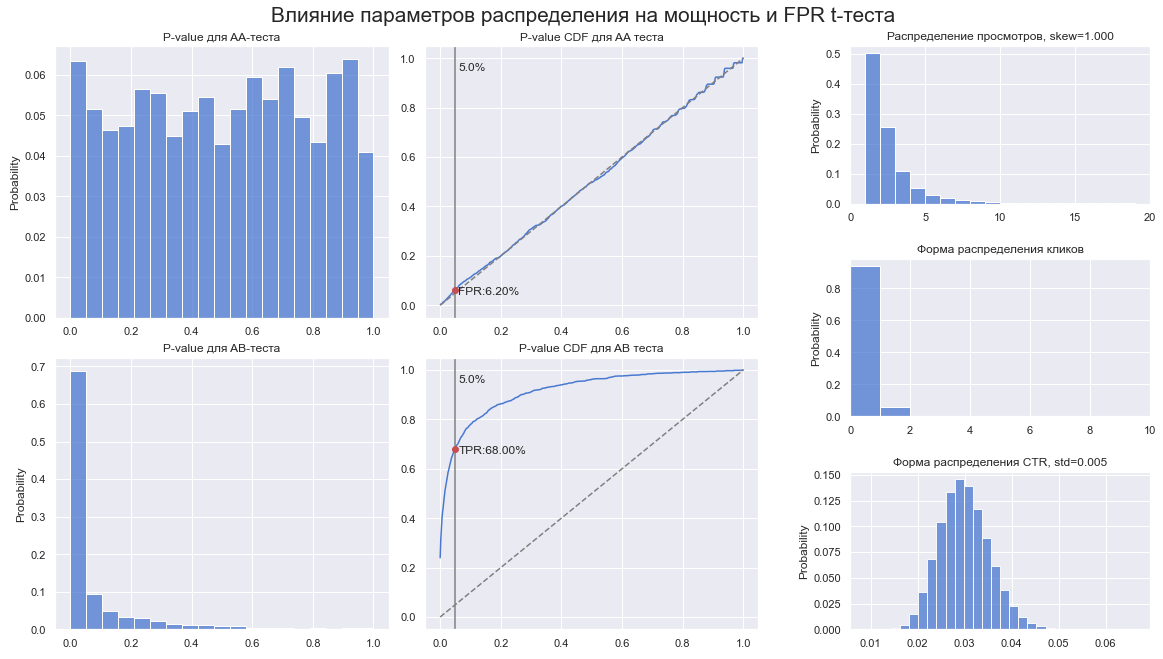

In [8]:
res = dash_drawer(data_aa=data_aa, data_ab=data_ab, stats_aa=stats_aa, control_test_kwargs=control_test_kwargs)

In [9]:
#Генерим картинки для разных skew
#Это нифига не быстро
skews = np.linspace(0.1, 5.0, num=50)
for ind, skew in enumerate(skews):
    dict_aa = generate_wrapper(views_skew=skew)
    data_aa = dict_aa['data']
    stats_aa = dict_aa['stats']
    dict_ab = generate_wrapper(uplift=0.2, views_skew=skew)
    data_ab = dict_ab['data']
    dash_drawer(data_aa=data_aa, data_ab=data_ab, stats_aa=stats_aa, control_test_kwargs=control_test_kwargs).savefig(f'pics/{str(ind+25).zfill(2)}_t_test_skew_{skew}.png')
    plt.close()

KeyboardInterrupt: 

In [12]:
#Собираем гифку из сохраненных картинок
p = Path('.')
filenames = p.glob('**/*.png')
image, *images = [Image.open(filename) for filename in sorted(filenames)]
image.save(fp='gifs/t_test.gif', format='GIF', append_images=images, save_all=True, duration=300, loop=1)
